<a href="https://colab.research.google.com/github/RealThanosP/pred-main-mod/blob/main/DataPrep_Models_dimitris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clone repository from github

Τα πρώτα ειναι copy paste απο τον κώδικα του θανου

In [1]:
# Load the data on the server session
!git clone https://github.com/RealThanosP/pred-main-mod

# Change your working directory inside the repository
%cd pred-main-mod

Cloning into 'pred-main-mod'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 73 (delta 32), reused 2 (delta 0), pack-reused 28 (from 2)
Receiving objects: 100% (73/73), 85.48 MiB | 5.00 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (24/24), done.
/content/pred-main-mod


# Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import os
import seaborn as sns

#Getting the sensor files in a list

In [3]:
folder_path = "data/condition+monitoring+of+hydraulic+systems"

# Define the list of sensors and their corresponding column names
sensors = [
    "PS1", "PS2", "PS3", "PS4", "PS5", "PS6",  # Pressure sensors
    "EPS1",  # Motor power
    "FS1", "FS2",  # Volume flow
    "TS1", "TS2", "TS3", "TS4",  # Temperature sensors
    "VS1",  # Vibration
    "CE",  # Cooling efficiency
    "CP",  # Cooling power
    "SE"  # Efficiency factor
]

In [4]:
# Gets all the text files from dataset
txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Keeps only the data that have a sensor name in the filename
sensor_file_path_list = [f"{folder_path}/{f}" for f in txt_files if any(sensor in f for sensor in sensors)]
sensor_file_path_list.sort()

#Loading Data

Based on the description the classification for the data is:

The target condition values are cycle-wise annotated in �profile.txt� (tab-delimited). As before, the row number represents the cycle number. The columns are

1: Cooler condition / %: 3: close to total failure 20: reduced effifiency 100: full efficiency

2: Valve condition / %: 100: optimal switching behavior 90: small lag 80: severe lag 73: close to total failure

3: Internal pump leakage: 0: no leakage 1: weak leakage 2: severe leakage

4: Hydraulic accumulator / bar: 130: optimal pressure 115: slightly reduced pressure 100: severely reduced pressure 90: close to total failure

5: stable flag: 0: conditions were stable 1: static conditions might not have been reached yet

In [5]:
# profile
profile = pd.read_csv("data/condition+monitoring+of+hydraulic+systems/profile.txt", sep="\t", header=None)
profile.columns = ["Cooler condition %", "Valve condition %", "Internal pump leakage", "Hydraulic accumulator / bar", "stable flag"]
profile.insert(0, "Cycle", [i + 1 for i in range(len(profile))]) # Insert Cycle column for easier plotting
profile

,Cycle,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar,stable flag
0,1,3,100,0,130,1
1,2,3,100,0,130,1
2,3,3,100,0,130,1
3,4,3,100,0,130,1
4,5,3,100,0,130,1
...,...,...,...,...,...,...
2200,2201,100,100,0,90,0
2201,2202,100,100,0,90,0
2202,2203,100,100,0,90,0
2203,2204,100,100,0,90,0


#Data plotting (profile)

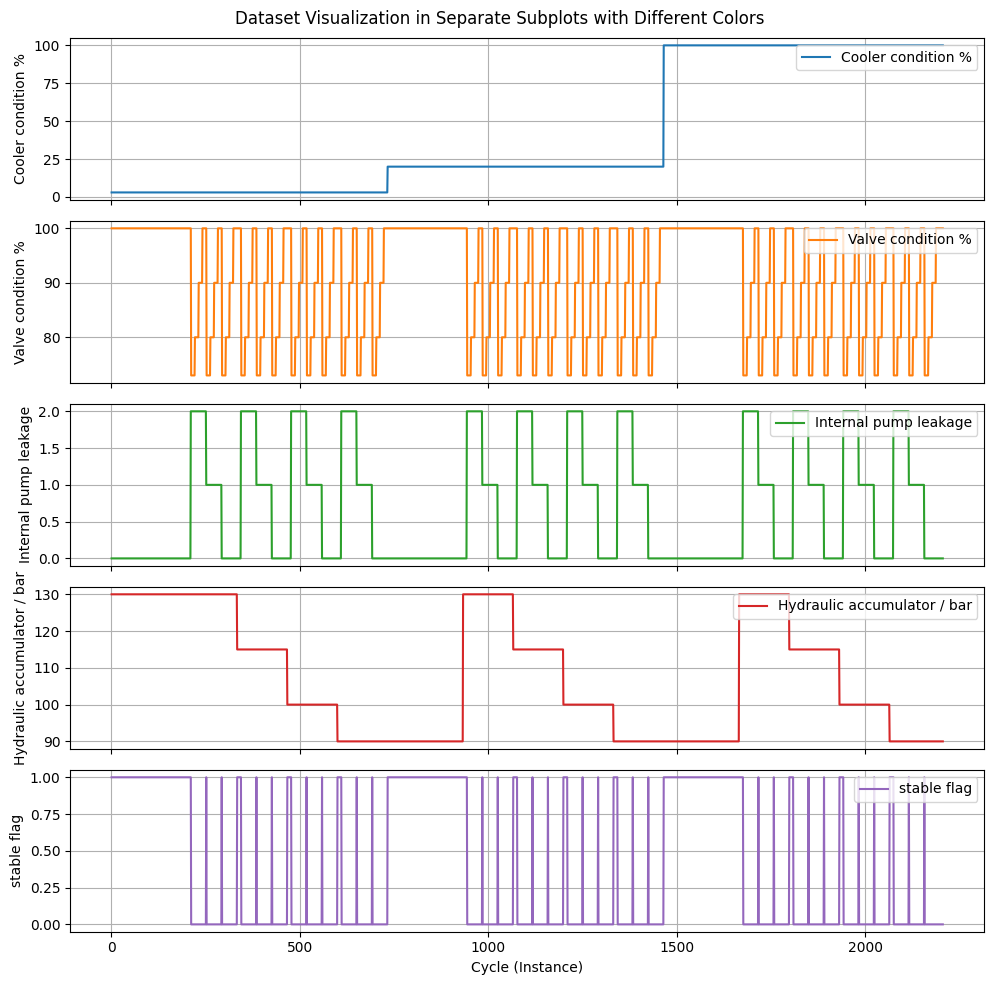

In [6]:
# Define colors for each subplot
colors = sns.color_palette("tab10", len(profile.columns) - 1)  # Use seaborn's color palette

# Create subplots
fig, axes = plt.subplots(nrows=len(profile.columns)-1, ncols=1, figsize=(10, 10), sharex=True)

# Plot each column in a separate subplot with a unique color
for i, (col, color) in enumerate(zip(profile.columns[1:], colors)):  # Exclude "Cycle"
    axes[i].plot(profile["Cycle"], profile[col], label=col, color=color, linewidth=1.5)
    axes[i].set_ylabel(col)
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

# Set common X-axis label
axes[-1].set_xlabel("Cycle (Instance)")
fig.suptitle("Dataset Visualization in Separate Subplots with Different Colors")

plt.tight_layout()
plt.show()

#Data preperation

Θα δοκιμασω να κανω ολα τα αρχεια των αισθητηρων να περιεχουν πληροφορειες mean, rms, max, min κλπ, να τα κάνω ένα ενιαίο dataset (και το profile μεσα) και να βαλω ως target column το stable flag.

In [7]:
import pandas as pd
import os

# load all the files as seperate DataFrames with the file name as name
for file_path in sensor_file_path_list:
    # remove the .txt
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # read the file and save it with the right name
    globals()[file_name] = pd.read_csv(file_path, sep="\t", header=None)

### Feature engineering

In [8]:
# function that does the feature engineering
def create_stats(sensor_name):
    # We get the DataFrame dynamically from the name
    df = globals()[sensor_name]

    # Calculate statistics
    stats = pd.DataFrame({
        'mean'+ sensor_name: df.mean(axis=1),
        'std'+ sensor_name: df.std(axis=1),
        'min'+ sensor_name: df.min(axis=1),
        'max'+ sensor_name: df.max(axis=1),
        'range'+ sensor_name: df.max(axis=1) - df.min(axis=1),
        'rms'+ sensor_name: (df.pow(2).mean(axis=1)).pow(0.5)
    })

    return stats

In [9]:
# dictionary to save the names as keys and the dataframes as values
stats_dfs = {}

for sensor in sensors:
    stats_dfs[f'{sensor}_stats'] = create_stats(sensor)

# Converts the keys of the dictionary to variables
globals().update(stats_dfs)

In [10]:
FS1_stats

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1
0,6.709815,3.015428,0.0,18.710,18.710,7.355220
1,6.715315,3.006248,0.0,18.712,18.712,7.356488
2,6.718522,3.014248,0.0,18.698,18.698,7.362682
3,6.720565,3.020176,0.0,18.896,18.896,7.366970
4,6.690308,3.011550,0.0,18.876,18.876,7.335840
...,...,...,...,...,...,...
2200,6.689930,3.001512,0.0,20.228,20.228,7.331386
2201,6.692182,3.005831,0.0,20.308,20.308,7.335206
2202,6.693277,2.991333,0.0,20.071,20.071,7.330287
2203,6.684128,3.003983,0.0,20.280,20.280,7.327103


### Compine the data by category

In [11]:
combined_stats_fs = pd.concat([FS1_stats, FS2_stats], axis=1)
combined_stats_ps = pd.concat([PS1_stats, PS2_stats, PS3_stats, PS4_stats, PS5_stats, PS6_stats], axis=1)
combined_stats_ts = pd.concat([TS1_stats, TS2_stats, TS3_stats, TS4_stats], axis=1)

In [12]:
combined_stats_ts

,meanTS1,stdTS1,minTS1,maxTS1,rangeTS1,rmsTS1,meanTS2,stdTS2,minTS2,maxTS2,...,minTS3,maxTS3,rangeTS3,rmsTS3,meanTS4,stdTS4,minTS4,maxTS4,rangeTS4,rmsTS4
0,35.621983,0.308230,35.156,36.152,0.996,35.623295,40.978767,0.154302,40.773,41.250,...,38.316,38.613,0.297,38.471108,31.745250,1.116478,30.363,33.594,3.231,31.764550
1,36.676967,0.585740,35.648,37.488,1.840,36.681566,41.532767,0.338234,41.031,42.105,...,38.668,39.254,0.586,38.979361,34.493867,0.435312,33.648,35.148,1.500,34.496568
2,37.880800,0.559169,36.879,38.621,1.742,37.884858,42.442450,0.390588,41.832,43.039,...,39.234,40.062,0.828,39.632732,35.646150,0.293889,35.098,36.141,1.043,35.647341
3,38.879050,0.516176,37.887,39.473,1.586,38.882419,43.403983,0.398476,42.805,43.988,...,40.023,40.934,0.911,40.404375,36.579467,0.262397,36.105,36.988,0.883,36.580392
4,39.803917,0.535374,38.789,40.391,1.602,39.807457,44.332750,0.372769,43.742,44.887,...,40.859,41.777,0.918,41.311576,37.427900,0.239571,36.992,37.781,0.789,37.428654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,35.313783,0.141893,35.000,35.516,0.516,35.314064,40.874800,0.071999,40.727,40.977,...,38.168,38.371,0.203,38.269323,30.404733,0.032142,30.363,30.488,0.125,30.404750
2201,35.321600,0.137743,34.988,35.516,0.528,35.321864,40.868883,0.071279,40.707,40.977,...,38.148,38.418,0.270,38.268317,30.416233,0.037951,30.367,30.488,0.121,30.416257
2202,35.319183,0.152040,34.984,35.520,0.536,35.319505,40.875950,0.073286,40.719,40.977,...,38.156,38.371,0.215,38.246450,30.426250,0.045413,30.367,30.496,0.129,30.426283
2203,35.324767,0.158769,35.000,35.531,0.531,35.325118,40.876067,0.063998,40.742,40.977,...,38.145,38.363,0.218,38.245806,30.414283,0.038725,30.363,30.488,0.125,30.414308


###Compine all the data

In [13]:
combined_data = pd.concat([combined_stats_fs, combined_stats_ps, combined_stats_ts, CE_stats, CP_stats, EPS1_stats, VS1_stats, SE_stats], axis=1)
combined_data

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,minVS1,maxVS1,rangeVS1,rmsVS1,meanSE,stdSE,minSE,maxSE,rangeSE,rmsSE
0,6.709815,3.015428,0.0,18.710,18.710,7.355220,10.304592,0.091772,10.148,10.446,...,0.532,0.624,0.092,0.577575,59.157183,23.763984,0.0,79.568,79.568,63.677996
1,6.715315,3.006248,0.0,18.712,18.712,7.356488,10.403098,0.019162,10.352,10.453,...,0.524,0.626,0.102,0.566494,59.335617,23.857918,0.0,80.441,80.441,63.878236
2,6.718522,3.014248,0.0,18.698,18.698,7.362682,10.366250,0.026361,10.296,10.443,...,0.529,0.662,0.133,0.577683,59.543150,23.923381,0.0,80.824,80.824,64.095055
3,6.720565,3.020176,0.0,18.896,18.896,7.366970,10.302678,0.026750,10.241,10.382,...,0.527,0.645,0.118,0.570233,59.794900,24.023005,0.0,80.930,80.930,64.365491
4,6.690308,3.011550,0.0,18.876,18.876,7.335840,10.237750,0.029170,10.179,10.312,...,0.524,0.660,0.136,0.578321,59.455267,23.972262,0.0,81.100,81.100,64.031400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,6.689930,3.001512,0.0,20.228,20.228,7.331386,10.184515,0.013701,10.147,10.224,...,0.512,0.618,0.106,0.551627,59.033100,23.635352,0.0,77.752,77.752,63.515559
2201,6.692182,3.005831,0.0,20.308,20.308,7.335206,10.177767,0.014669,10.133,10.233,...,0.507,0.584,0.077,0.547897,59.068000,23.638396,0.0,77.592,77.592,63.549111
2202,6.693277,2.991333,0.0,20.071,20.071,7.330287,10.176172,0.014749,10.127,10.225,...,0.502,0.597,0.095,0.545755,59.132350,23.633405,0.0,77.773,77.773,63.607104
2203,6.684128,3.003983,0.0,20.280,20.280,7.327103,10.178353,0.014619,10.129,10.230,...,0.502,0.585,0.083,0.537302,58.970800,23.600817,0.0,77.568,77.568,63.445019


In [14]:
# the dataset for scaling
profile_without_last_column = profile.iloc[:, :-1]
data_for_scalling = pd.concat([combined_data, profile_without_last_column], axis=1)
data_for_scalling.head()

,meanFS1,stdFS1,minFS1,maxFS1,rangeFS1,rmsFS1,meanFS2,stdFS2,minFS2,maxFS2,...,stdSE,minSE,maxSE,rangeSE,rmsSE,Cycle,Cooler condition %,Valve condition %,Internal pump leakage,Hydraulic accumulator / bar
0,6.709815,3.015428,0.0,18.710,18.710,7.355220,10.304592,0.091772,10.148,10.446,...,23.763984,0.0,79.568,79.568,63.677996,1,3,100,0,130
1,6.715315,3.006248,0.0,18.712,18.712,7.356488,10.403098,0.019162,10.352,10.453,...,23.857918,0.0,80.441,80.441,63.878236,2,3,100,0,130
2,6.718522,3.014248,0.0,18.698,18.698,7.362682,10.366250,0.026361,10.296,10.443,...,23.923381,0.0,80.824,80.824,64.095055,3,3,100,0,130
3,6.720565,3.020176,0.0,18.896,18.896,7.366970,10.302678,0.026750,10.241,10.382,...,24.023005,0.0,80.930,80.930,64.365491,4,3,100,0,130
4,6.690308,3.011550,0.0,18.876,18.876,7.335840,10.237750,0.029170,10.179,10.312,...,23.972262,0.0,81.100,81.100,64.031400,5,3,100,0,130


### Scaling the data

εδω καλο θα ηταν να ονοματησω σωστα τισ στηλες του Dataframe

In [15]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data_for_scalling)
scaled_data_dtset = pd.DataFrame(scaled_data)
scaled_data_dtset

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,-0.202694,0.0,-0.063981,-0.063981,0.456140,-1.731265,-0.902469,0.87141,-0.819277,1.387554
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,-0.153763,0.0,0.091880,0.091880,0.485438,-1.729694,-0.902469,0.87141,-0.819277,1.387554
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,-0.119662,0.0,0.160258,0.160258,0.517161,-1.728123,-0.902469,0.87141,-0.819277,1.387554
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,-0.067767,0.0,0.179183,0.179183,0.556728,-1.726552,-0.902469,0.87141,-0.819277,1.387554
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,-0.094199,0.0,0.209534,0.209534,0.507847,-1.724981,-0.902469,0.87141,-0.819277,1.387554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,-0.269700,0.0,-0.388199,-0.388199,0.432374,1.724981,1.386695,0.87141,-0.819277,-1.046703
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,-0.268115,0.0,-0.416764,-0.416764,0.437283,1.726552,1.386695,0.87141,-0.819277,-1.046703
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,-0.270715,0.0,-0.384450,-0.384450,0.445768,1.728123,1.386695,0.87141,-0.819277,-1.046703
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,-0.287690,0.0,-0.421049,-0.421049,0.422054,1.729694,1.386695,0.87141,-0.819277,-1.046703


In [16]:
profile_last_column = profile.iloc[:, -1]
total_data = pd.concat([scaled_data_dtset, profile_last_column], axis = 1)
total_data

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,stable flag
0,0.495101,-0.130443,-0.021301,-3.143240,-3.143235,0.546497,1.458639,18.562454,1.206381,1.677334,...,0.0,-0.063981,-0.063981,0.456140,-1.731265,-0.902469,0.87141,-0.819277,1.387554,1
1,0.500427,-0.179022,-0.021301,-3.138813,-3.138809,0.548169,1.677960,0.497722,1.653167,1.693157,...,0.0,0.091880,0.091880,0.485438,-1.729694,-0.902469,0.87141,-0.819277,1.387554,1
2,0.503533,-0.136685,-0.021301,-3.169798,-3.169794,0.556338,1.595919,2.288859,1.530520,1.670553,...,0.0,0.160258,0.160258,0.517161,-1.728123,-0.902469,0.87141,-0.819277,1.387554,1
3,0.505511,-0.105318,-0.021301,-2.731581,-2.731577,0.561995,1.454379,2.385506,1.410063,1.532668,...,0.0,0.179183,0.179183,0.556728,-1.726552,-0.902469,0.87141,-0.819277,1.387554,1
4,0.476211,-0.150963,-0.021301,-2.775846,-2.775842,0.520934,1.309819,2.987783,1.274275,1.374439,...,0.0,0.209534,0.209534,0.507847,-1.724981,-0.902469,0.87141,-0.819277,1.387554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,0.475845,-0.204087,-0.021301,0.216421,0.216422,0.515060,1.191293,-0.860944,1.204191,1.175523,...,0.0,-0.388199,-0.388199,0.432374,1.724981,1.386695,0.87141,-0.819277,-1.046703,0
2201,0.478025,-0.181232,-0.021301,0.393479,0.393479,0.520099,1.176268,-0.620172,1.173529,1.195866,...,0.0,-0.416764,-0.416764,0.437283,1.726552,1.386695,0.87141,-0.819277,-1.046703,0
2202,0.479086,-0.257953,-0.021301,-0.131053,-0.131052,0.513611,1.172717,-0.600236,1.160388,1.177783,...,0.0,-0.384450,-0.384450,0.445768,1.728123,1.386695,0.87141,-0.819277,-1.046703,0
2203,0.470227,-0.191012,-0.021301,0.331509,0.331509,0.509411,1.177575,-0.632400,1.164768,1.189085,...,0.0,-0.421049,-0.421049,0.422054,1.729694,1.386695,0.87141,-0.819277,-1.046703,0


# Model training

### splitting

In [17]:
from sklearn.model_selection import train_test_split

X = total_data.iloc[:, :-1]
y = total_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### fitting and testing models

Function to get the score of each model

In [18]:
def get_score(model, X_train, X_test ,y_train, y_test):
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [19]:
# importing the  models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [20]:
print("rf score:" + str(get_score(RandomForestClassifier(), X_train, X_test, y_train, y_test)))
print("svm score:" + str(get_score(SVC(), X_train, X_test, y_train, y_test)))
print("xgb score:" + str(get_score(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), X_train, X_test, y_train, y_test)))

rf score:0.9795918367346939
svm score:0.927437641723356


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:00:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


xgb score:0.981859410430839


I'm going to try to use kfold cross validation

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
folds = StratifiedKFold(n_splits=10)

scores_svc = [] #list with the svm scores
scores_rf = [] #list with the random forest scores

scores_rf = cross_val_score(RandomForestClassifier(max_depth= None,
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 50), X, y, cv=10)
scores_svc = cross_val_score(SVC(C= 1, gamma= 'scale',  kernel = 'linear'), X, y, cv=10)

In [38]:
scores_svc

array([0.86425339, 0.95927602, 0.96832579, 0.90497738, 0.97737557,
       0.98181818, 0.83636364, 0.99090909, 0.99090909, 0.82727273])

In [39]:
scores_rf

array([0.56561086, 0.99095023, 0.80542986, 0.88235294, 0.91402715,
       0.95909091, 0.69545455, 0.98636364, 0.95909091, 0.61363636])

function that calculates the average score of a model

In [40]:
def get_av(score_list):
  av_score = np.median(score_list)
  return av_score

In [41]:
get_av(scores_svc)

np.float64(0.9638009049773756)

In [42]:
get_av(scores_rf)

np.float64(0.8981900452488687)

we can see that the svm model is more acurate than the random forest model, so im going to use GrisSearchCV to select the best parameters

In [35]:
from sklearn.model_selection import GridSearchCV
# defining parameters
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}


grid_search_svc = GridSearchCV(estimator=SVC(), param_grid=param_grid_svc,
                           cv=5, n_jobs=-1, verbose=2)

#fitting and testing
grid_search_svc.fit(X_train, y_train)

grid_search_svc.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

now i will try GridSearchCV for the Randomforest

In [36]:
# defining parameters
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf,
                           cv=5, n_jobs=-1, verbose=2)

#fitting and testing
grid_search_rf.fit(X_train, y_train)

grid_search_rf.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

i load the models with these parameters and still the svc model is more accurate